In [6]:
! pip install neo4j

     |████████████████████████████████| 196 kB 9.7 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for neo4j: filename=neo4j-5.15.0-py3-none-any.whl size=272484 sha256=4c995bb8e0a1e7f0326cb378b186a4984cbfc6a93572d5fc044885377561576b
  Stored in directory: /Users/Roberto/Library/Caches/pip/wheels/e7/22/f5/780dc9f90d498a16e2e768fe34350e531566fe6c0b09a23358
Successfully built neo4j


In [2]:
import pandas as pd
import tkinter as tk
from tkinter import messagebox
from tkinter import filedialog
import numpy as np
from tkinter import filedialog
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from neo4j import GraphDatabase
from pathlib import Path
import os
from datetime import datetime

## conection Neo4j

In [3]:
class Neo4jConnector:
    def __init__(self):
        self._driver = None

    def close(self):
         if self._driver is not None:
            self._driver.close()

    def connect(self, uri, user, password):
        self._driver = GraphDatabase.driver(uri, auth=(user, password))

    def save_results(self, file_name, file_path, results_df):
        if not results_df.empty:
            with self._driver.session() as session:
                # Begin a transaction
                with session.begin_transaction() as tx:
                    # Créer le nœud Source
                    source_query = (
                        "MERGE (s:Source {nom: $source_name, chemin: $file_path})"
                        )
                    tx.run(source_query, source_name='s', file_path=file_path)

                    # Créer le nœud Table
                    table_query = "MERGE (t:Table {nom: $table_name})"
                    tx.run(table_query, table_name=file_name)

                    # Créer la relation POSSEDE
                    posede_query = (
                        "MATCH (s:Source {nom: $source_name, chemin: $file_path}), "
                        "(t:Table {nom: $table_name}) "
                        "CREATE (s)-[:POSSEDE]->(t)"
                    )
                    tx.run(posede_query, source_name='s', file_path=file_path, table_name=file_name)

                    # Parcourir les résultats et les stocker dans Neo4j
                    for _, row in results_df.iterrows():
                        column = row['Colonne']
                        resultats = row['Resultats']

                        # Créer le nœud Colonne
                        colonne_query = f"MERGE (c:Colonne {{nom: '{column}'}})"
                        tx.run(colonne_query)

                        # Créer la relation CONTIENT
                        contient_query = (
                            "MATCH (s:Source{nom:$source_name})-[:POSSEDE]->(t:Table {nom: $table_name}), "
                            "(c:Colonne {nom: $column_name}) "
                            "CREATE (t)-[:CONTIENT]->(c)"
                        )
                        tx.run(contient_query, source_name='s', table_name=file_name, column_name=column)

                        parameters = ""
                        for result in resultats:
                            # Enclose result[0] in backticks if it contains spaces
                            parameter_name = f"`{result[0]}`"
                            parameters += f" {parameter_name}: '{result[1]}', "

                        # Remove the trailing comma
                        parameters = parameters.rstrip(', ')

                        # Créer la relation EFFECTUE
                        effectue_query = (
                            "MATCH (s:Source{nom:$source_name})-[:POSSEDE]->(t:Table {nom: $table_name})-[:CONTIENT]->(c:Colonne {nom: $column_name}) "
                            f"CREATE (c)-[:EFFECTUE]->(a:Analyse {{{parameters}}})"
                        )
                        tx.run(effectue_query, source_name='s', table_name=file_name, column_name=column)


## Main code

histogramme impossible pour ce type de donnes
        Colonne                                          Resultats
0      DATAFLOW  [(Valeur la plus fréquente, ESTAT:ISOC_EB_ICS(...
1   LAST UPDATE                                                 []
2          freq                                                 []
3      size_emp                                                 []
4       nace_r2                                                 []
5      indic_is               [(Valeur la plus fréquente, E_SISC)]
6          unit                                                 []
7           geo                                                 []
8   TIME_PERIOD                                                 []
9     OBS_VALUE  [(box plot, box plot/Figure(288x216)_OBS_VALUE...
10     OBS_FLAG               [(Valeurs distinctes, nan, u, b, c)]


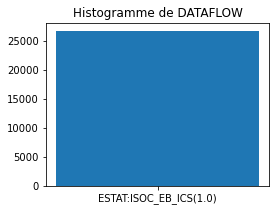

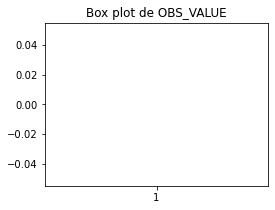

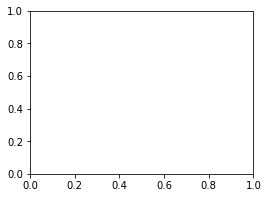

In [6]:
class DataFrameAnalyzerApp:
    def __init__(self, root):
        self.root = root
        self.root.title("DataFrame Analyzer")

        # Frame pour les widgets
        self.frame = tk.Frame(root)
        self.frame.pack(padx=10, pady=10)

        # Bouton pour charger un fichier
        self.load_button = tk.Button(self.frame, text="Charger un fichier", command=self.load_file)
        self.load_button.grid(row=0, column=0, pady=(0, 10))

        # Liste des opérations disponibles
        self.operations = ["Statistiques", "Valeur la plus fréquente", "Valeurs distinctes", "Valeurs manquantes", "Histogrammes", "box plot"]

        # Label, Checkbuttons, et Text pour chaque colonne
        self.column_labels = []
        self.column_checkbuttons = []
        self.column_results = []
        self.columns = []

        # Bouton pour exécuter les opérations
        self.analyze_button = tk.Button(self.frame, text="Analyser", command=self.analyze)
        self.analyze_button.grid(row=0, column=2, pady=(0, 10))

        # Bouton pour enregistrer les résultats
        self.save_button = tk.Button(self.frame, text="Enregistrer les résultats", command=self.save_results)
        self.save_button.grid(row=0, column=3, pady=(0, 10))

        # DataFrame pour stocker les résultats
        self.results_df = pd.DataFrame()
        #save results
        self.file_name = None
        self.file_path = None

        # Fenêtre pour les histogrammes
        self.histogram_window = None
        self.histogram_canvas_frame = None
        self.histogram_row = 0

    
    def save_results(self):
        if self.file_name != None and self.file_path != None:
            uri = "bolt://localhost:7687/test"  # Remplacez cela par votre URI Neo4j
            user = "neo4j"
            password = "LogisticData"

            connector = Neo4jConnector()
            connector.connect(uri, user, password)
            connector.save_results(self.file_name, self.file_path, self.results_df)
            connector.close()
            tk.messagebox.showinfo("Enregistrement réussi", "Les résultats ont été enregistrés avec succès dans Neo4j.")
        else:
            print("enregistrement impossible, erreur lors du chargement du fichier")
            tk.messagebox.showinfo("ECHEC d'enregistrement")

    def create_image_window(self):

        if self.histogram_window:
            self.histogram_window.destroy()

        # Créer une seule fenêtre pour les histogrammes
        self.histogram_window = tk.Toplevel(self.root)
        self.histogram_window.title("Histogrammes")

            # Frame pour les canvases des histogrammes
        self.histogram_canvas_frame = tk.Frame(self.histogram_window)
        self.histogram_canvas_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=1)

            # Ajouter un bouton de fermeture
        close_button = tk.Button(self.histogram_window, text="Fermer", command=self.histogram_window.destroy)
        close_button.pack(side=tk.BOTTOM)

        # Réinitialiser la ligne de la grille
        self.histogram_row = 0

    def save_image(figure, column, chart, save_path='images'):
        # Create the save directory if it doesn't exist
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Define the file name based on column, chart type, and date/time
        file_name = f"{column}_{chart.replace(' ', '_')}_{current_datetime}.png"
        file_path = os.path.join(save_path, file_name)

        # Save the figure
        plt.savefig(file_path)

        # Close the figure to free up resources
        #plt.close(figure)

        return file_path   

    def create_image_canvas(self, column, chart):
        # Vérifier si la colonne existe dans le DataFrame
        if column not in self.df.columns:
            tk.messagebox.showerror("Erreur", f"La colonne {column} n'existe pas dans le DataFrame.")
            return

        # Obtenir les données de la colonne
        data = self.df[column]

        # Créer un canevas pour l'histogramme
        figure, ax = plt.subplots(figsize=(4, 3))
        if chart == "histogram":
            ax.hist(data, bins='auto')
            ax.set_title(f'Histogramme de {column}')
        elif chart == "box plot":
            ax.boxplot(data)
            ax.set_title(f'Box plot de {column}')

        # Ajouter le canevas à la fenêtre des histogrammes
        canvas = FigureCanvasTkAgg(figure, master=self.histogram_canvas_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(side=tk.LEFT, padx=5, pady=5)

        # Incrémenter le suivi de la ligne
        self.histogram_row += 1

        # Si nous avons atteint trois histogrammes, passer à une nouvelle ligne
        if self.histogram_row % 3 == 0:
            self.histogram_canvas_frame = tk.Frame(self.histogram_window)
            self.histogram_canvas_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=1)

        return self.save_image(figure, column, chart)



    def load_file(self):
        # Ouvrir une boîte de dialogue pour sélectionner un fichier
        file_path = filedialog.askopenfilename(filetypes=[("CSV Files", "*.csv"), ("Excel Files", "*.xlsx")])

        if file_path:
            # Charger le fichier dans un DataFrame
            if file_path.endswith('.csv'):
                self.df = pd.read_csv(file_path)
            elif file_path.endswith('.xlsx'):
                self.df = pd.read_excel(file_path)
            else:
                tk.messagebox.showerror("Erreur", "Format de fichier non pris en charge.")
                return

            # Créer des widgets pour chaque colonne
            self.create_column_widgets()

            #save file name and path
            self.file_name = Path(file_path).name
            self.file_path = file_path
    
    def create_column_widgets(self):
        # Supprimer les anciens widgets s'ils existent
        for label_list, checkbox_list, result_list in zip(self.column_labels, self.column_checkbuttons,
                                                        self.column_results):
            for label in label_list:
                label = str(label)
                label.grid_forget()
            for checkbox in checkbox_list:
                checkbox.grid_forget()
            for result in result_list:
                result.grid_forget()

        self.column_labels = []
        self.column_checkbuttons = []
        self.column_results = []
        self.columns = []

        # Créer des widgets pour chaque colonne du DataFrame
        for i, column in enumerate(self.df.columns):
            label = tk.Label(self.frame, text=f"{column}:")
            label.grid(row=i + 1, column=0, sticky='w')

            current_column = 1  # Variable pour suivre la colonne actuelle

            checkbuttons_vars = [tk.IntVar() for _ in self.operations]
            checkboxes = []

            # Ajouter les checkbox en fonction du type de données de la colonne
            column_type = self.df[column].dtype
            for operation, var in zip(self.operations, checkbuttons_vars):
                if operation == "box plot" and not (pd.api.types.is_numeric_dtype(column_type) and np.issubdtype(self.df[column].dtype, np.number)):
                    #checkboxes.append(None)
                    continue  # Ignorer "box plot" pour les colonnes non numériques
                if operation == "Statistiques" and not pd.api.types.is_numeric_dtype(column_type):
                    #checkboxes.append(None)
                    continue  # Ignorer "Statistiques" pour les colonnes non numériques
                checkboxes.append(tk.Checkbutton(self.frame, text=operation, variable=var))

            for checkbox in checkboxes:
                checkbox.grid(row=i + 1, column=current_column, sticky='w')
                current_column += 1  # Passer à la colonne suivante

            result = tk.Text(self.frame, height=3, width=30)
            result.grid(row=i + 1, column=current_column, sticky='w')

            self.column_labels.append(label)
            self.column_checkbuttons.append(checkbuttons_vars)
            self.column_results.append(result)
            self.columns.append(column)


    def analyze(self):
        if hasattr(self, 'df'):
            results_data = []

            for column, checkbuttons_vars, result_text in zip(self.columns, self.column_checkbuttons, self.column_results):
                selected_operations = [self.operations[idx] for idx, var in enumerate(checkbuttons_vars) if var.get() == 1]

                result_texts = []

                for operation in selected_operations:
                    if operation == "Valeur la plus fréquente":
                        result_texts.append(("Valeur la plus fréquente", self.df[column].mode().iloc[0]))
                    elif operation == "Valeurs distinctes":
                        result_texts.append(("Valeurs distinctes", f"{', '.join(map(str, self.df[column].unique()))}"))
                    elif operation == "Valeurs manquantes":
                        result_texts.append(("Missing", self.df[column].isnull().mean() * 100))
                    elif operation == "Statistiques":
                        if pd.api.types.is_numeric_dtype(self.df[column]) and np.issubdtype(self.df[column].dtype, np.number):
                            result_texts.append(("min", self.df[column].min()))
                            result_texts.append(("mean", self.df[column].mean()))
                            result_texts.append(("max", self.df[column].max()))
                            result_texts.append(("std", self.df[column].std()))
                        else:
                            print(f"La colonne {column} n'est pas numérique, pas de stats possible")
                    elif operation == "Histogrammes":
                        if not self.histogram_window:
                            self.create_image_window()
                        try:
                            # Créer un nouvel histogramme dans la fenêtre existante
                            image_path = self.create_image_canvas(column, chart="histogram")
                            result_texts.append(("histogram", image_path))
                        except Exception as e: 
                            print(f"histogramme impossible pour ce type de donnes")
                    elif operation == "box plot":
                        if pd.api.types.is_numeric_dtype(self.df[column]) and np.issubdtype(self.df[column].dtype, np.number):
                            if not self.histogram_window:
                                self.create_image_window()

                            # Créer un nouvel histogramme dans la fenêtre existante
                            image_path = self.create_image_canvas(column, chart="box plot")
                            result_texts.append(("box plot", image_path))
                        else:
                            print(f"La colonne {column} n'est pas numérique, box plot impossible")
                    else:
                        print("Opération non prise en charge")
                #result_texts.append(("data_type", f"{type(self.df[column][0])}"))
                result_text.delete(1.0, tk.END)  # Effacer le contenu précédent
                result_text.insert(tk.END, (result_texts))

                results_data.append([column, result_texts])

            # Mettre à jour le DataFrame des résultats
            self.results_df = pd.DataFrame(results_data, columns=['Colonne', 'Resultats'])

            # Afficher les résultats dans la console pour le débogage
            print(self.results_df)

            tk.messagebox.showinfo("Analyse réussi")
        else:
            tk.messagebox.showinfo("Echec de l'analyse.")

if __name__ == "__main__":
    root = tk.Tk()
    app = DataFrameAnalyzerApp(root)
    root.mainloop()

## Profilage
 - Origin port, dest port le chemin le plus emprunté - histogramme &   \\ 
 - Le port le plus emprunté : valeur la plus frequente - histogramme &   \\ 
 - Le meilleur client : qui fait le plus de commandes, combien de clients differents
   * histogramme
   * compter les valeurs distinctes &   \\ 
 - carrier (transporteur) le plus plus utilisé - histogramme &   \\ 
 - Ratio de retard : probabilité de retard &   \\ 
 - Produit le plus et le moins vendu : histogramme &   \\ 
 - Produit en fontcion d'origine et destination : scaterplot &   \\ 
 - Poids moyen des commandes, quantite moy : calcul moyenne &   \\ 
 - client, produits : distinct values &   \\ 
 - Display the number of distinct values for each column &   \\ 